In [3]:
!pip install av

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/huggingface_hub-0.29.1-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 28.7 MB/s eta 0:00:0000:0100:01


In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 11-30-10.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30 
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("output_with_hands_colored_VFR.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_01.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752157624.587689 22783896 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752157624.610801 22784119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752157624.619192 22784119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752157626.776558 22784119 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 19918
Frames with at least 1 hand detected: 17596
Detection rate: 88.34%


In [11]:
df = pd.read_csv("hand_landmarks_01.csv")

print("Shape:", df.shape)
df

Shape: (632163, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.000000,Left,0,NaN,NaN,NaN,0
1,0,0.000000,Left,1,NaN,NaN,NaN,0
2,0,0.000000,Left,2,NaN,NaN,NaN,0
3,0,0.000000,Left,3,NaN,NaN,NaN,0
4,0,0.000000,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
632158,19917,331.966667,Right,16,NaN,NaN,NaN,0
632159,19917,331.966667,Right,17,NaN,NaN,NaN,0
632160,19917,331.966667,Right,18,NaN,NaN,NaN,0
632161,19917,331.966667,Right,19,NaN,NaN,NaN,0


In [13]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [15]:
df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,51,0.850000,Left,1,0.156385,0.149666,0.158686,0.171426,0.180528,0.185562,...,-0.004669,-0.001600,-0.005107,-0.007957,-0.004976,-0.001042,-0.005605,-0.006333,-0.002673,0.001610
1,52,0.866667,Left,1,0.155113,0.149716,0.156871,0.167704,0.173993,0.183644,...,-0.012779,-0.011465,-0.010742,-0.014258,-0.013013,-0.010824,-0.012205,-0.014094,-0.011320,-0.007918
2,53,0.883333,Left,1,0.142506,0.131772,0.136183,0.145179,0.152139,0.166993,...,-0.010892,-0.008438,-0.012322,-0.014129,-0.008832,-0.005033,-0.012796,-0.012574,-0.007062,-0.002448
3,54,0.900000,Left,1,0.134895,0.122693,0.129572,0.141404,0.148504,0.158709,...,-0.003218,-0.001853,-0.005124,-0.005740,-0.002970,-0.000625,-0.005446,-0.005059,-0.001184,0.002345
4,107,1.783333,Left,1,0.638472,0.619165,0.598164,0.581288,0.574819,0.618596,...,-0.063599,-0.066792,-0.036360,-0.056276,-0.057673,-0.055235,-0.037529,-0.051865,-0.051939,-0.049335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24450,19710,328.500000,Left,1,0.311720,0.297826,0.293309,0.294820,0.295616,0.311654,...,-0.005726,-0.007252,-0.004126,-0.007286,-0.008743,-0.009435,-0.006742,-0.009787,-0.010199,-0.009948
24451,19711,328.516667,Left,1,0.311947,0.297670,0.292881,0.294617,0.296289,0.311032,...,-0.005791,-0.007276,-0.004394,-0.007549,-0.009065,-0.009800,-0.007341,-0.010199,-0.010448,-0.010084
24452,19712,328.533333,Left,1,0.309626,0.296338,0.291970,0.294021,0.296531,0.309468,...,-0.003254,-0.004459,-0.003085,-0.005451,-0.005482,-0.005231,-0.006067,-0.008032,-0.006915,-0.005576
24453,19713,328.550000,Left,1,0.309902,0.296132,0.292008,0.293910,0.295692,0.308468,...,-0.002538,-0.003812,-0.001892,-0.004284,-0.004513,-0.004368,-0.004847,-0.006611,-0.005756,-0.004677


In [21]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,51,0.850,Left,1,0.156385,0.149666,0.158686,0.171426,0.180528,0.185562,...,-0.004669,-0.001600,-0.005107,-0.007957,-0.004976,-0.001042,-0.005605,-0.006333,-0.002673,0.001610
1,52,0.867,Left,1,0.155113,0.149716,0.156871,0.167704,0.173993,0.183644,...,-0.012779,-0.011465,-0.010742,-0.014258,-0.013013,-0.010824,-0.012205,-0.014094,-0.011320,-0.007918
2,53,0.883,Left,1,0.142506,0.131772,0.136183,0.145179,0.152139,0.166993,...,-0.010892,-0.008438,-0.012322,-0.014129,-0.008832,-0.005033,-0.012796,-0.012574,-0.007062,-0.002448
3,54,0.900,Left,1,0.134895,0.122693,0.129572,0.141404,0.148504,0.158709,...,-0.003218,-0.001853,-0.005124,-0.005740,-0.002970,-0.000625,-0.005446,-0.005059,-0.001184,0.002345
4,107,1.783,Left,1,0.638472,0.619165,0.598164,0.581288,0.574819,0.618596,...,-0.063599,-0.066792,-0.036360,-0.056276,-0.057673,-0.055235,-0.037529,-0.051865,-0.051939,-0.049335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24450,19710,328.500,Left,1,0.311720,0.297826,0.293309,0.294820,0.295616,0.311654,...,-0.005726,-0.007252,-0.004126,-0.007286,-0.008743,-0.009435,-0.006742,-0.009787,-0.010199,-0.009948
24451,19711,328.517,Left,1,0.311947,0.297670,0.292881,0.294617,0.296289,0.311032,...,-0.005791,-0.007276,-0.004394,-0.007549,-0.009065,-0.009800,-0.007341,-0.010199,-0.010448,-0.010084
24452,19712,328.533,Left,1,0.309626,0.296338,0.291970,0.294021,0.296531,0.309468,...,-0.003254,-0.004459,-0.003085,-0.005451,-0.005482,-0.005231,-0.006067,-0.008032,-0.006915,-0.005576
24453,19713,328.550,Left,1,0.309902,0.296132,0.292008,0.293910,0.295692,0.308468,...,-0.002538,-0.003812,-0.001892,-0.004284,-0.004513,-0.004368,-0.004847,-0.006611,-0.005756,-0.004677


In [19]:
df2 = pd.read_csv("hand_lable_01.csv")

print("Shape:", df.shape)
df2

Shape: (632163, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,DC_01,44:20.7,NaN,251.117,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0,331.967,60,NaN,other,NaN,START,80.550,D:/Data Science/UOB/DS_project/Full Study/01/2...,4833,NaN,NaN
1,DC_01,44:20.7,NaN,251.117,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0,331.967,60,NaN,other,NaN,STOP,81.267,D:/Data Science/UOB/DS_project/Full Study/01/2...,4876,NaN,NaN
2,DC_01,44:20.7,NaN,251.117,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0,331.967,60,NaN,lift,NaN,START,81.283,D:/Data Science/UOB/DS_project/Full Study/01/2...,4877,NaN,NaN
3,DC_01,44:20.7,NaN,251.117,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0,331.967,60,NaN,lift,NaN,STOP,83.650,D:/Data Science/UOB/DS_project/Full Study/01/2...,5019,NaN,NaN
4,DC_01,44:20.7,NaN,251.117,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0,331.967,60,NaN,hold,NaN,START,83.667,D:/Data Science/UOB/DS_project/Full Study/01/2...,5020,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,DC_01,44:20.7,NaN,251.117,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0,331.967,60,NaN,hold,NaN,STOP,314.300,D:/Data Science/UOB/DS_project/Full Study/01/2...,18858,NaN,NaN
216,DC_01,44:20.7,NaN,251.117,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0,331.967,60,NaN,place,NaN,START,314.317,D:/Data Science/UOB/DS_project/Full Study/01/2...,18859,NaN,NaN
217,DC_01,44:20.7,NaN,251.117,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0,331.967,60,NaN,place,NaN,STOP,316.917,D:/Data Science/UOB/DS_project/Full Study/01/2...,19015,NaN,NaN
218,DC_01,44:20.7,NaN,251.117,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0,331.967,60,NaN,other,NaN,START,316.933,D:/Data Science/UOB/DS_project/Full Study/01/2...,19016,NaN,NaN


In [23]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,other,80.550,81.267,4833,4876
1,lift,81.283,83.650,4877,5019
2,hold,83.667,98.800,5020,5928
3,adjust,98.817,108.867,5929,6532
4,hold,108.883,114.383,6533,6863
...,...,...,...,...,...
105,hold,307.083,309.200,18425,18552
106,adjust,309.217,314.083,18553,18845
107,hold,314.100,314.300,18846,18858
108,place,314.317,316.917,18859,19015


In [27]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_91152/222154802.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,51,0.850,Left,1,0.156385,0.149666,0.158686,0.171426,0.180528,0.185562,...,-0.001600,-0.005107,-0.007957,-0.004976,-0.001042,-0.005605,-0.006333,-0.002673,0.001610,NaN
1,52,0.867,Left,1,0.155113,0.149716,0.156871,0.167704,0.173993,0.183644,...,-0.011465,-0.010742,-0.014258,-0.013013,-0.010824,-0.012205,-0.014094,-0.011320,-0.007918,NaN
2,53,0.883,Left,1,0.142506,0.131772,0.136183,0.145179,0.152139,0.166993,...,-0.008438,-0.012322,-0.014129,-0.008832,-0.005033,-0.012796,-0.012574,-0.007062,-0.002448,NaN
3,54,0.900,Left,1,0.134895,0.122693,0.129572,0.141404,0.148504,0.158709,...,-0.001853,-0.005124,-0.005740,-0.002970,-0.000625,-0.005446,-0.005059,-0.001184,0.002345,NaN
4,107,1.783,Left,1,0.638472,0.619165,0.598164,0.581288,0.574819,0.618596,...,-0.066792,-0.036360,-0.056276,-0.057673,-0.055235,-0.037529,-0.051865,-0.051939,-0.049335,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24450,19710,328.500,Left,1,0.311720,0.297826,0.293309,0.294820,0.295616,0.311654,...,-0.007252,-0.004126,-0.007286,-0.008743,-0.009435,-0.006742,-0.009787,-0.010199,-0.009948,other
24451,19711,328.517,Left,1,0.311947,0.297670,0.292881,0.294617,0.296289,0.311032,...,-0.007276,-0.004394,-0.007549,-0.009065,-0.009800,-0.007341,-0.010199,-0.010448,-0.010084,other
24452,19712,328.533,Left,1,0.309626,0.296338,0.291970,0.294021,0.296531,0.309468,...,-0.004459,-0.003085,-0.005451,-0.005482,-0.005231,-0.006067,-0.008032,-0.006915,-0.005576,other
24453,19713,328.550,Left,1,0.309902,0.296132,0.292008,0.293910,0.295692,0.308468,...,-0.003812,-0.001892,-0.004284,-0.004513,-0.004368,-0.004847,-0.006611,-0.005756,-0.004677,other


In [29]:
print(df_wide['behavior'].value_counts(dropna=False))


behavior
hold      6547
adjust    5016
NaN       4314
rotate    3670
press     1815
other     1539
place      914
lift       640
Name: count, dtype: int64


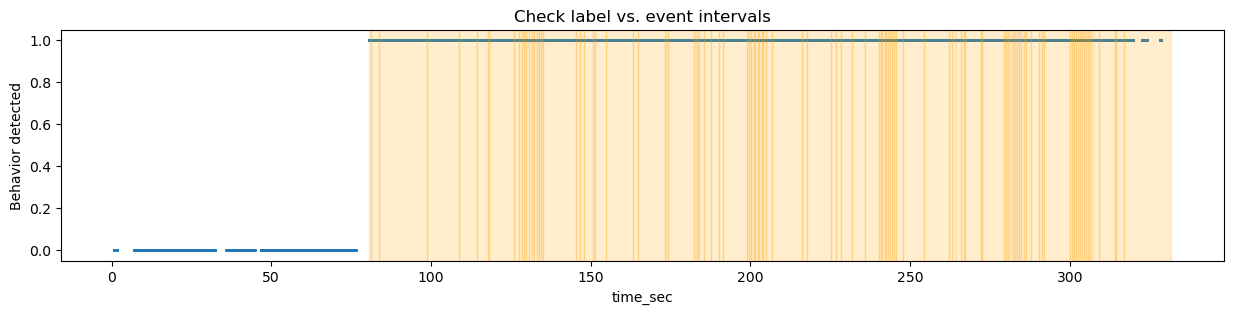

In [31]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()


In [113]:
df_wide[(df_wide['time_sec'] >= 81.2) & (df_wide['time_sec'] <= 83.7)][['time_sec', 'behavior']]

,time_sec,behavior
4348,81.200,other
4349,81.217,other
4350,81.233,other
4351,81.250,other
4352,81.267,other
...,...,...
4540,83.667,hold
4541,83.683,hold
4542,83.683,hold
4543,83.700,hold


In [115]:
nan_counts = df_wide.isna().sum()

total_rows = len(df_wide)

nan_report = pd.DataFrame({
    'num_nan': nan_counts,
    'percent_nan': (nan_counts / total_rows) * 100
})

nan_report

,num_nan,percent_nan
frame,0,0.000000
time_sec,0,0.000000
hand,0,0.000000
hand_detected,0,0.000000
x_0,0,0.000000
...,...,...
z_17,0,0.000000
z_18,0,0.000000
z_19,0,0.000000
z_20,0,0.000000


In [117]:
df_wide_clean = df_wide.dropna()

df_wide_clean

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
4314,4838,80.633,Left,1,0.562638,0.523307,0.482645,0.453211,0.428097,0.500351,...,0.023250,0.028924,0.040879,0.040476,0.037134,0.040757,0.047972,0.050100,0.050478,other
4315,4839,80.650,Left,1,0.568650,0.525218,0.484482,0.452202,0.425792,0.501131,...,0.017942,0.029138,0.037961,0.035304,0.031126,0.042559,0.047509,0.047854,0.047420,other
4316,4840,80.667,Left,1,0.608788,0.557545,0.508360,0.473195,0.442089,0.518432,...,0.088957,0.051530,0.078208,0.091393,0.097686,0.066829,0.087819,0.099258,0.106655,other
4317,4841,80.683,Left,1,0.649046,0.593075,0.538306,0.499576,0.468654,0.543082,...,0.063482,0.053335,0.076139,0.072194,0.064933,0.070201,0.086469,0.086850,0.084640,other
4318,4842,80.700,Left,1,0.650377,0.594110,0.538319,0.499342,0.467740,0.541353,...,0.073443,0.059745,0.085387,0.082217,0.074459,0.077140,0.094935,0.095359,0.092450,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24450,19710,328.500,Left,1,0.311720,0.297826,0.293309,0.294820,0.295616,0.311654,...,-0.007252,-0.004126,-0.007286,-0.008743,-0.009435,-0.006742,-0.009787,-0.010199,-0.009948,other
24451,19711,328.517,Left,1,0.311947,0.297670,0.292881,0.294617,0.296289,0.311032,...,-0.007276,-0.004394,-0.007549,-0.009065,-0.009800,-0.007341,-0.010199,-0.010448,-0.010084,other
24452,19712,328.533,Left,1,0.309626,0.296338,0.291970,0.294021,0.296531,0.309468,...,-0.004459,-0.003085,-0.005451,-0.005482,-0.005231,-0.006067,-0.008032,-0.006915,-0.005576,other
24453,19713,328.550,Left,1,0.309902,0.296132,0.292008,0.293910,0.295692,0.308468,...,-0.003812,-0.001892,-0.004284,-0.004513,-0.004368,-0.004847,-0.006611,-0.005756,-0.004677,other


In [119]:
behavior_counts = df_wide_clean['behavior'].value_counts()

print(behavior_counts)

behavior
hold      6547
adjust    5016
rotate    3670
press     1815
other     1539
place      914
lift       640
Name: count, dtype: int64


In [121]:
df_wide_clean['dataset_id'] = '01'

cols = df_wide_clean.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide_clean = df_wide_clean[cols]

df_wide_clean

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_91152/4170222099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide_clean['dataset_id'] = '01'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
4314,01,4838,80.633,Left,1,0.562638,0.523307,0.482645,0.453211,0.428097,...,0.023250,0.028924,0.040879,0.040476,0.037134,0.040757,0.047972,0.050100,0.050478,other
4315,01,4839,80.650,Left,1,0.568650,0.525218,0.484482,0.452202,0.425792,...,0.017942,0.029138,0.037961,0.035304,0.031126,0.042559,0.047509,0.047854,0.047420,other
4316,01,4840,80.667,Left,1,0.608788,0.557545,0.508360,0.473195,0.442089,...,0.088957,0.051530,0.078208,0.091393,0.097686,0.066829,0.087819,0.099258,0.106655,other
4317,01,4841,80.683,Left,1,0.649046,0.593075,0.538306,0.499576,0.468654,...,0.063482,0.053335,0.076139,0.072194,0.064933,0.070201,0.086469,0.086850,0.084640,other
4318,01,4842,80.700,Left,1,0.650377,0.594110,0.538319,0.499342,0.467740,...,0.073443,0.059745,0.085387,0.082217,0.074459,0.077140,0.094935,0.095359,0.092450,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24450,01,19710,328.500,Left,1,0.311720,0.297826,0.293309,0.294820,0.295616,...,-0.007252,-0.004126,-0.007286,-0.008743,-0.009435,-0.006742,-0.009787,-0.010199,-0.009948,other
24451,01,19711,328.517,Left,1,0.311947,0.297670,0.292881,0.294617,0.296289,...,-0.007276,-0.004394,-0.007549,-0.009065,-0.009800,-0.007341,-0.010199,-0.010448,-0.010084,other
24452,01,19712,328.533,Left,1,0.309626,0.296338,0.291970,0.294021,0.296531,...,-0.004459,-0.003085,-0.005451,-0.005482,-0.005231,-0.006067,-0.008032,-0.006915,-0.005576,other
24453,01,19713,328.550,Left,1,0.309902,0.296132,0.292008,0.293910,0.295692,...,-0.003812,-0.001892,-0.004284,-0.004513,-0.004368,-0.004847,-0.006611,-0.005756,-0.004677,other


In [126]:
df_wide_clean.to_csv("handlandmark_wide_01.csv", index=False)